In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import torch
from greedy_models.mono_flat_glm import Mono_Flat_GLM

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)

In [3]:
T_train = 998 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
E_no = E_neural.shape[1]
I_no = I_neural.shape[1]
device = torch.device("cuda")
sub_no = 10

batch_size = 100000
iter_no = 9990*3
epoch_no = iter_no*batch_size//T_train 
print(epoch_no)

60


In [4]:
V_train = V[:T_train].to(device)
V_test = V[T_train:T_train + T_test].to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

In [5]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Mono_Flat_GLM(sub_no, E_no, I_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

32023


In [7]:
temp_list = np.logspace(0,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
    temp = temp_list[temp_count]
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    batch_pred, out_filters = model(batch_E_neural, batch_I_neural, temp, False)
    loss = torch.var(batch_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%100 == 0:
        model.eval()
        test_V_pred, test_out_filters = model(test_E_neural, test_I_neural, 0, True)
            
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        print(i, test_score)

<ipython-input-7-a0762f1ffd06>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.06816732187757335
100 0.47386196991802676
200 0.34525351248514957
300 0.26463304013939126
400 0.17918728114602422
500 0.3258423993738183
600 0.2876245882119025
700 0.5393771955421076
800 0.5507324759760731
900 0.6236056076803105
1000 0.6243636253441576
1100 0.6947938920962343
1200 0.7004058403413168
1300 0.6384404964393495
1400 0.6520196934716496
1500 0.7683423350157537
1600 0.8232143895217239
1700 0.842353927621434
1800 0.8737615966437564
1900 0.8893507785877557
2000 0.9256908162139028
2100 0.9352827286130193
2200 0.9431068989422183
2300 0.9476474615087845
2400 0.9432026166670492
2500 0.9439393643569163
2600 0.9479156598503047
2700 0.9484858423584771
2800 0.9509021188369151
2900 0.9514463074963119
3000 0.950732234283787
3100 0.952291738251638
3200 0.9541294891269093
3300 0.9535570480281252
3400 0.9549361362940645
3500 0.9550207525326542
3600 0.9558475133093521
3700 0.9579070054665042
3800 0.9581880992974748
3900 0.9584176395425561
4000 0.9600041609031053
4100 0.9603242516603699
42

KeyboardInterrupt: 

In [8]:
clust_array = np.zeros((E_no))
for i in range(E_no):
    clust_array[i] = torch.argmax(model.C_syn_e_logit[:,i])

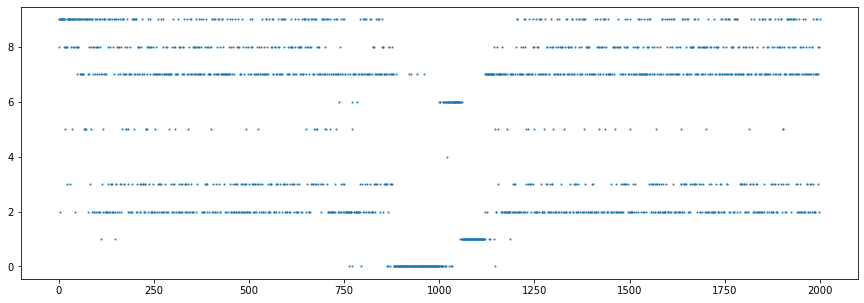

In [9]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), clust_array, s=1)

In [10]:
eloc = np.load("/media/hdd01/sklee/CA1_clust4-60/data/Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")

den_array = np.zeros((E_no))
clust_array = np.zeros((E_no))
for i in range(E_no):
    den_array[i] = eloc[i,0]
    clust_array[i] = torch.argmax(model.C_syn_e_logit[:,i])

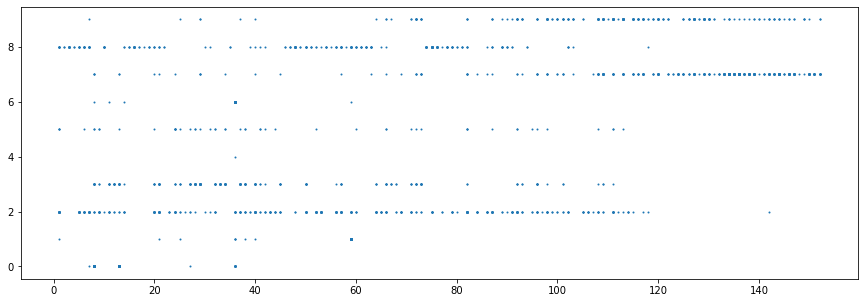

In [11]:
plt.figure(figsize = (15,5))
plt.scatter(den_array, clust_array, s=1)